Energy Consumption Patterns Model: Behavior and Technology

This model simulates household electricity demand under varying user behavior and
technology configurations across an entire year (8760 hours). It loops through four
defined scenarios (A–D), each with specific beta (behavioral multiplier) and tau
(technology efficiency) parameters. The model uses Linopy to compute total electricity
demand, cost, and CO₂ emissions.

In [2]:
import linopy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Section 1: Libraries imported successfully.")

Section 1: Libraries imported successfully.


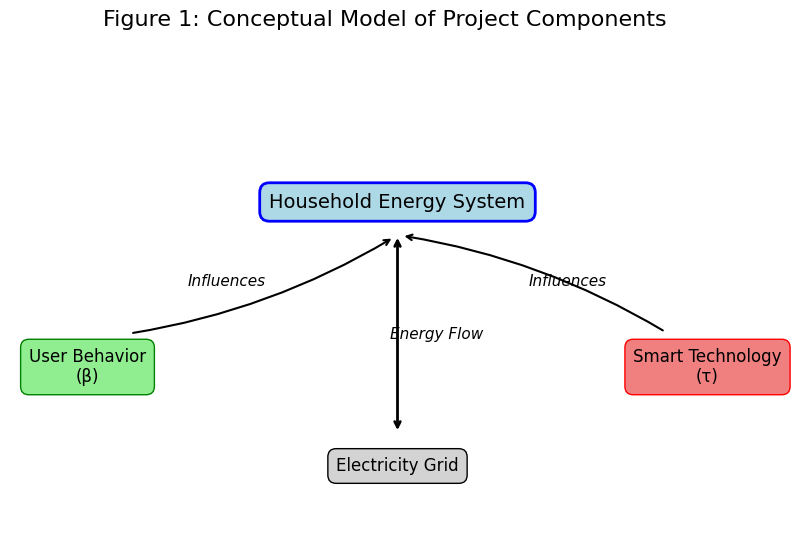

In [4]:
# Create a figure and axes object
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.axis('off') # Hide the axes

# Define properties for boxes and arrows
box_props = dict(boxstyle='round,pad=0.5', fc='lightblue', ec='b', lw=2)
arrow_props = dict(arrowstyle='->', connectionstyle='arc3,rad=0.1', shrinkA=5, shrinkB=5,
                   patchA=None, patchB=None, color='black', lw=1.5)

# Draw the main components
ax.text(5, 5, 'Household Energy System', ha='center', va='center', bbox=box_props, fontsize=14)
ax.text(1, 2.5, 'User Behavior\n(β)', ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', ec='g'), fontsize=12)
ax.text(9, 2.5, 'Smart Technology\n(τ)', ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', fc='lightcoral', ec='r'), fontsize=12)
ax.text(5, 1, 'Electricity Grid', ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', fc='lightgrey', ec='k'), fontsize=12)

# Draw arrows to show influences and interactions
ax.annotate('', xy=(5, 4.5), xytext=(1.5, 3), arrowprops=arrow_props)
ax.annotate('', xy=(5, 4.5), xytext=(8.5, 3), arrowprops=arrow_props)
ax.annotate('', xy=(5, 1.5), xytext=(5, 4.5), arrowprops=dict(arrowstyle='<->', color='black', lw=2))

# Add labels for arrows
ax.text(2.8, 3.8, 'Influences', ha='center', va='center', fontsize=11, style='italic')
ax.text(7.2, 3.8, 'Influences', ha='center', va='center', fontsize=11, style='italic')
ax.text(5.5, 3, 'Energy Flow', ha='center', va='center', fontsize=11, style='italic')

# Set title and display the figure
fig.suptitle("Figure 1: Conceptual Model of Project Components", fontsize=16)
plt.show()


Section 2: Data and Parameter Definition

This section defines all the input data required for the model, as outlined in Section 4 of the project report. This process mirrors the data setup in 'Household_model_with_for_loops.ipynb', where parameters are defined using pandas Series and DataFrames for clear, labeled data management.


--- 2.1 Time Horizon Definition (Set T) ---
Defines the set T from the methodology.
To run the full year simulation, set SIMULATION_DAYS = 365.

In [6]:
SIMULATION_DAYS = 10
TIME_HORIZON = 24 * SIMULATION_DAYS
time_index = pd.to_datetime(pd.date_range(start='2025-01-01', periods=TIME_HORIZON, freq='h', name="time"))
print(f"Section 2: Data setup for a {SIMULATION_DAYS}-day ({TIME_HORIZON}-hour) simulation.")

# --- 2.2 Baseline Demand Profiles (Parameter D_j,t^base) ---
# Creates synthetic but realistic hourly demand profiles for a typical
# German household. This data represents the "careless" baseline consumption.
np.random.seed(42) # for reproducible randomness

Section 2: Data setup for a 10-day (240-hour) simulation.


In [7]:
# Lighting Demand Profile
lighting_baseline = np.sin(np.linspace(0, 2 * np.pi, 24)) * -0.4 + 0.5
lighting_baseline = np.tile(lighting_baseline, TIME_HORIZON // 24)
lighting_baseline[lighting_baseline < 0.05] = 0.05 # Ensure a minimum base level


In [8]:
# Water Heating Demand Profile
water_heating_baseline = (np.sin(np.linspace(0, 4 * np.pi, 24)) * -0.8 + 1.0)
water_heating_baseline = np.tile(water_heating_baseline, TIME_HORIZON // 24)

In [9]:
# Combine into a pandas DataFrame for easy handling
baseline_demand_df = pd.DataFrame({
    'lighting': lighting_baseline,
    'water_heating': water_heating_baseline
}, index=time_index)

 --- 2.3 Scenario Construction (Parameters β and τ) ---
Defines the behavioral and technological multipliers for each of the four

In [10]:
scenario_parameters = {
    'A_Baseline':        {'β': 1.2, 'τ': 0.0},
    'B_EfficientBehavior': {'β': 0.8, 'τ': 0.0},
    'C_SmartTechnology':   {'β': 1.2, 'τ': 0.3},
    'D_Combined':          {'β': 0.8, 'τ': 0.3}
}

--- 2.4 Economic and Environmental Parameters ---
Defines the cost and emissions data used in the objective function and analysis.

In [11]:
# Time-of-Use (ToU) Tariff (Parameter C_t^ToU)
tou_tariff = pd.Series(0.20, index=time_index) # Off-peak rate
tou_tariff[tou_tariff.index.hour.isin(range(7, 11))] = 0.35 # Morning peak rate
tou_tariff[tou_tariff.index.hour.isin(range(17, 21))] = 0.45 # Evening peak rate


 Peak Demand Penalty (Parameter C^peak)

In [13]:
peak_penalty_cost = 50.0 # €/kW per year. Scale for shorter simulations.
peak_penalty_cost_scaled = peak_penalty_cost * (SIMULATION_DAYS / 365)
# CO₂ Emissions Factor (Parameter E_grid)
co2_intensity_factor = 0.4 # kgCO₂/kWh

print("Section 2: All data and parameters have been defined.")


Section 2: All data and parameters have been defined.



Section 3: Optimization Model Function

This section contains the core function that builds and solves the linopy optimization model. It takes the scenario parameters as input and returns a dictionary with the key results, directly implementing the mathematical formulation.

In [22]:
def run_household_energy_simulation(scenario_name, params):
    """
    Builds, solves, and analyzes the household energy model for a given scenario.

    This function implements the complete methodology described in the report.
    It defines the decision variables, constraints, and objective function
    and uses a solver to find the cost-optimal energy consumption pattern.

    Args:
        scenario_name (str): The name of the scenario being run (e.g., 'A_Baseline').
        params (dict): A dictionary containing the 'β' and 'τ' parameters for the scenario.

    Returns:
        dict: A dictionary containing the simulation results.
    """
    print(f"\n--- Running optimization for Scenario: {scenario_name} ---")

    # Step 3.1: Initialize a new linopy Model instance
    model = linopy.Model()

    # Step 3.2: Calculate Adjusted Demand
    # This directly implements the equation: Adjusted Demand = Base * β * (1 - τ)
    beta = params['β']
    tau = params['τ']
    adjusted_demand = baseline_demand_df.sum(axis=1) * beta * (1 - tau)
    adjusted_demand.name = "Adjusted Demand (kWh)"

    # Step 3.3: Define Decision Variables (P_t^grid and P^peak)
    # These are the unknown values the model needs to determine.
    # We use 'coords' to create a time-indexed variable, as in 'Advanced_linopy.ipynb'.
    grid_supply = model.add_variables(lower=0, coords=[time_index], name='grid_supply')
    peak_demand = model.add_variables(lower=0, name='peak_demand')

    # Step 3.4: Define Constraints
    # This section implements the rules from the mathematical formulation.
    
    # Constraint 1: Energy Balance (P_t^grid = Adjusted Demand)
    model.add_constraints(grid_supply == adjusted_demand, name="energy_balance_constraint")

    # Constraint 2: Peak Demand Definition (P^peak >= P_t^grid)
    model.add_constraints(peak_demand >= grid_supply, name="peak_definition_constraint")
    
    # Non-negativity is handled by the 'lower=0' argument in add_variables.

    # Step 3.5: Define the Objective Function
    # The goal is to minimize total cost. We build the expression as shown in the exercises.
    
    # Cost from hourly energy consumption (vectorized multiplication)
    total_energy_cost = (grid_supply * tou_tariff).sum()
    
    # Cost from the peak demand penalty
    peak_demand_penalty = peak_demand * peak_penalty_cost_scaled
    
    # The total objective is the sum of these two costs
    total_cost_objective = total_energy_cost + peak_demand_penalty
    
    model.add_objective(total_cost_objective) # Default sense is 'min'

    # Step 3.6: Solve the Optimization Problem
    # This command calls an underlying solver (like HiGHS or Gurobi) to find the
    # optimal values for the decision variables that minimize the objective function.
    model.solve()
    print(f"Solver status: {model.status}")

    # Step 3.7: Collect and Return Key Results
    # After solving, we extract the optimal values for analysis and reporting.
    results = {
        'Scenario': scenario_name,
        'Total Cost (€)': model.objective.value,
        'Energy Cost (€)': (model.solution['grid_supply'] * tou_tariff).sum().item(),
        'Peak Cost (€)': model.solution['peak_demand'].item() * peak_penalty_cost_scaled,
        'Total Emissions (kgCO2)': (model.solution['grid_supply'].sum() * co2_intensity_factor).item(),
        'Peak Usage (kW)': model.solution['peak_demand'].item(),
        'Hourly Supply (kWh)': model.solution['grid_supply'].to_pandas()
    }
    
    return results

print("Section 3: Optimization model function defined.")

Section 3: Optimization model function defined.


Section 4: Simulation Execution
=============================================================================
This section iterates through all defined scenarios, calls the simulation
function for each one, and stores the results in a structured format.

In [23]:
print("\nSection 4: Starting scenario simulations...")
all_results = []
for name, params in scenario_parameters.items():
    scenario_result = run_household_energy_simulation(name, params)
    all_results.append(scenario_result)

# Convert the list of result dictionaries into a clean pandas DataFrame
results_summary_df = pd.DataFrame(all_results).set_index('Scenario')

# Separate the hourly supply data for later plotting
hourly_supply_data = {res['Scenario']: res.pop('Hourly Supply (kWh)') for res in all_results}

print("\nSection 4: All scenarios have been simulated successfully.")


Section 4: Starting scenario simulations...

--- Running optimization for Scenario: A_Baseline ---
Restricted license - for non-production use only - expires 2026-11-23
Read LP format model from file C:\Users\linus\AppData\Local\Temp\linopy-problem-3f4a4nuc.lp
Reading time = 0.01 seconds
obj: 480 rows, 241 columns, 720 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11+.0 (26120.2))

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 480 rows, 241 columns and 720 nonzeros
Model fingerprint: 0x486040aa
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+00]
Presolve removed 480 rows and 241 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
      

=============================================================================
# Section 5: Results Visualization
# =============================================================================

In [24]:
print("\nSection 5: Generating results and visualizations...")

# --- 5.1 Display Summary Table of Results (for Report Section 5.1) ---
print(f"\n--- Summary of Simulation Results for {SIMULATION_DAYS} Days ---")
display(results_summary_df[['Total Cost (€)', 'Total Emissions (kgCO2)', 'Peak Usage (kW)']].round(2))



Section 5: Generating results and visualizations...

--- Summary of Simulation Results for 10 Days ---


,Total Cost (€),Total Emissions (kgCO2),Peak Usage (kW)
Scenario,,,
A_Baseline,131.48,172.80,3.11
B_EfficientBehavior,87.65,115.20,2.07
C_SmartTechnology,92.03,120.96,2.18
D_Combined,61.36,80.64,1.45


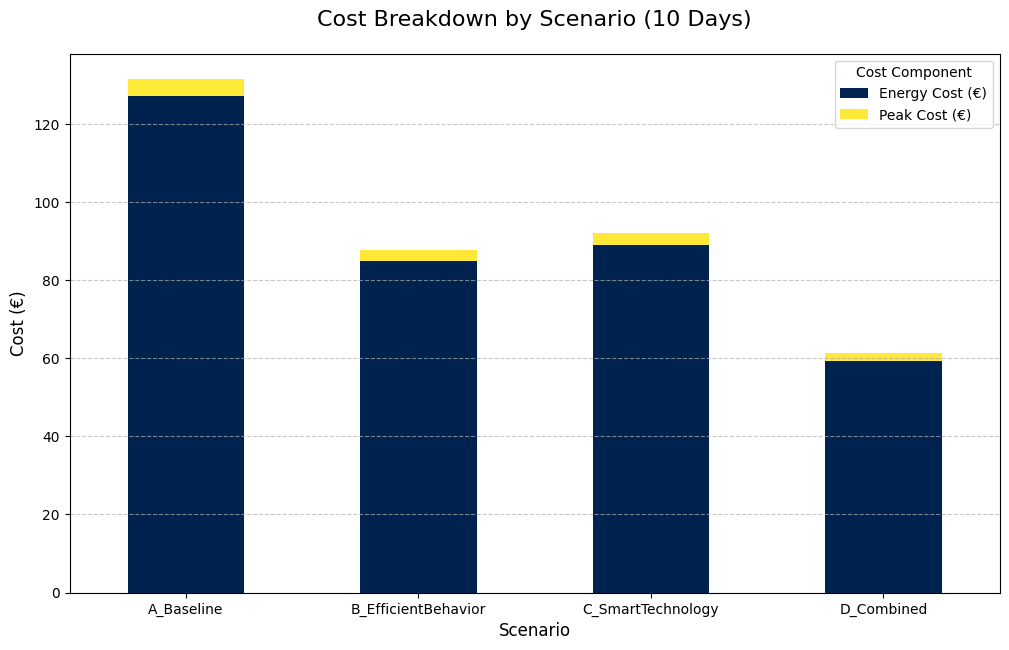

In [25]:
# --- 5.2 Plot: Cost Analysis (for Report Section 5.3) ---
cost_breakdown_df = results_summary_df[['Energy Cost (€)', 'Peak Cost (€)']]
ax = cost_breakdown_df.plot(kind='bar', stacked=True, figsize=(12, 7), rot=0, colormap='cividis')
ax.set_title(f'Cost Breakdown by Scenario ({SIMULATION_DAYS} Days)', fontsize=16, pad=20)
ax.set_ylabel('Cost (€)', fontsize=12)
ax.set_xlabel('Scenario', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='Cost Component')
plt.show()

In [28]:
# --- 5.3 Plot: Energy Usage Profiles (for Report Section 5.2) ---
fig_daily = go.Figure()
for scenario_name, hourly_series in hourly_supply_data.items():
    fig_daily.add_trace(go.Scatter(
        x=hourly_series.index[:24], 
        y=hourly_series.values[:24], 
        mode='lines+markers', 
        name=scenario_name
    ))

fig_daily.update_layout(
    title='Comparative Daily Electricity Consumption Profile (First 24 Hours)',
    xaxis_title='Hour of the Day',
    yaxis_title='Electricity Consumption (kWh)',
    legend_title='Scenario',
    font=dict(size=12),
    template='plotly_white'
)
fig_daily.show()

print("\nSection 5: Report visualizations are complete.")


Section 5: Report visualizations are complete.
